In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import data_manipulation as dm

In [43]:
(predictions_folder, all_data, test_data) = dm.load_data()

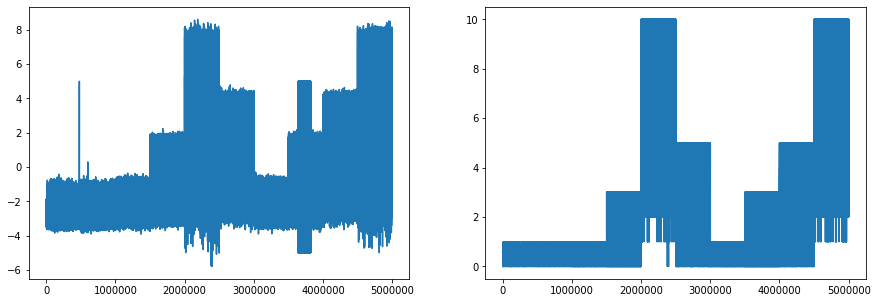

In [3]:
dm.plot_signal_and_channels(all_data)

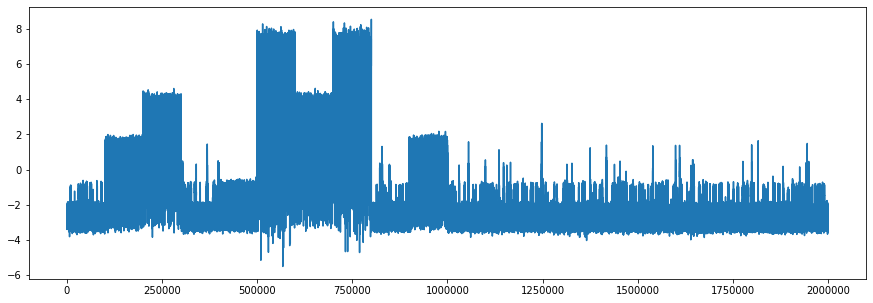

In [4]:
dm.plot_signal(test_data)

In [48]:
dm.load_shifted_values([all_data, test_data], 10)

In [57]:
def get_index_mod_int(col, d):
    return pd.Series(range(len(col))).floordiv(d)

In [59]:
index_feat = get_index_mod_int(all_data['time'], 50000)
all_data['index_feat'] = index_feat

In [36]:
from sklearn.metrics import f1_score, make_scorer

def partial_f1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

macro_f1 = make_scorer(partial_f1_score)

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [38]:
nb_noise_variables = 5
mean_signal = all_data['signal'].mean()
std_signal = all_data['signal'].std()
for i in range(nb_noise_variables):
    new_variable = np.random.normal(mean_signal, std_signal, len(all_data['signal']))
    all_data['random_'+str(i)] = new_variable

In [60]:
train_data = all_data.drop(columns=['time', 'open_channels'])

In [61]:
X = train_data.values
y = all_data['open_channels'].values

np.random.seed(34993)
sample_size = 100000
random_permutation = np.random.choice(len(X), sample_size, replace=False)
X_small = X[random_permutation, :]
y_small = y[random_permutation]

clf = RandomForestClassifier(n_estimators=100, random_state=100)
cv_score = cross_val_score(clf, X_small, y_small, cv=5, scoring=macro_f1)
print(f'sample_size = {sample_size}, mean_score = {np.mean(cv_score)}, std = {np.std(cv_score)}')

dm.training_done()

sample_size = 100000, mean_score = 0.9280082747111125, std = 0.0024326075061608075


In [62]:
clf.fit(X_small, y_small)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

In [63]:
importances = list(zip(train_data.columns, clf.feature_importances_))
importances.sort(key=lambda x: x[1], reverse=True)
for feat, imp in importances:
    print(f'{feat} importance = {imp}')

signal importance = 0.384927104365624
previous_signal_1 importance = 0.10173373925729344
next_signal_1 importance = 0.09684278458356702
previous_signal_2 importance = 0.06338952314813276
next_signal_2 importance = 0.055689029108225464
index_feat importance = 0.05245766946018346
next_signal_3 importance = 0.036727326886366
previous_signal_3 importance = 0.03662962988204894
previous_signal_4 importance = 0.024110985680317512
next_signal_5 importance = 0.02232444298997034
next_signal_4 importance = 0.020199402597535984
previous_signal_6 importance = 0.016579089159481718
previous_signal_5 importance = 0.015766938971084183
next_signal_9 importance = 0.011318161699237952
previous_signal_8 importance = 0.011166094954251022
next_signal_7 importance = 0.01076454198558445
previous_signal_9 importance = 0.010688060456429898
next_signal_6 importance = 0.009939669192991316
next_signal_8 importance = 0.00940036532374234
previous_signal_7 importance = 0.009345440297932292


In [64]:
train_data.head()

,signal,previous_signal_1,next_signal_1,previous_signal_2,next_signal_2,previous_signal_3,next_signal_3,previous_signal_4,next_signal_4,previous_signal_5,next_signal_5,previous_signal_6,next_signal_6,previous_signal_7,next_signal_7,previous_signal_8,next_signal_8,previous_signal_9,next_signal_9,index_feat
0,-2.7600,-2.7600,-2.8557,-2.7600,-2.4074,-2.7600,-3.1404,-2.76,-3.1525,-2.76,-2.6418,-2.76,-2.6993,-2.76,-2.5935,-2.76,-2.6682,-2.76,-2.7586,0
1,-2.8557,-2.7600,-2.4074,-2.7600,-3.1404,-2.7600,-3.1525,-2.76,-2.6418,-2.76,-2.6993,-2.76,-2.5935,-2.76,-2.6682,-2.76,-2.7586,-2.76,-3.1136,0
2,-2.4074,-2.8557,-3.1404,-2.7600,-3.1525,-2.7600,-2.6418,-2.76,-2.6993,-2.76,-2.5935,-2.76,-2.6682,-2.76,-2.7586,-2.76,-3.1136,-2.76,-2.6221,0
3,-3.1404,-2.4074,-3.1525,-2.8557,-2.6418,-2.7600,-2.6993,-2.76,-2.5935,-2.76,-2.6682,-2.76,-2.7586,-2.76,-3.1136,-2.76,-2.6221,-2.76,-2.7316,0
4,-3.1525,-3.1404,-2.6418,-2.4074,-2.6993,-2.8557,-2.5935,-2.76,-2.6682,-2.76,-2.7586,-2.76,-3.1136,-2.76,-2.6221,-2.76,-2.7316,-2.76,-2.9028,0


In [69]:
def compute_closest_chunk(training_df, vec):
    chunk_size = len(vec)
    nb_chunks = len(training_df) // chunk_size
    min_dist = 1e100
    min_chunk_idx = -1
    for i in range(nb_chunks):
        new_dist = np.sum((vec - training_df['signal'].iloc[i*chunk_size:(i+1)*chunk_size].values)**2)
        if new_dist < min_dist:
            min_dist = new_dist
            min_chunk_idx = i
    return min_chunk_idx

test_data['index_feat'] = np.zeros(len(test_data))
chunk_size = 50000
nb_chunks = len(test_data) // chunk_size
for i in range(nb_chunks):
    test_data['index_feat'].iloc[i*chunk_size:(i+1)*chunk_size] = compute_closest_chunk(train_data, test_data['signal'].iloc[i*chunk_size:(i+1)*chunk_size])

In [70]:
test_data.head()

,time,signal,previous_signal_1,next_signal_1,previous_signal_2,next_signal_2,previous_signal_3,next_signal_3,previous_signal_4,next_signal_4,...,next_signal_5,previous_signal_6,next_signal_6,previous_signal_7,next_signal_7,previous_signal_8,next_signal_8,previous_signal_9,next_signal_9,index_feat
0,500.0001,-2.649831,-2.649831,-2.849463,-2.649831,-2.860094,-2.649831,-2.435126,-2.649831,-2.615657,...,-2.566088,-2.649831,-2.738020,-2.649831,-2.779051,-2.649831,-2.848083,-2.649831,-2.376114,0.0
1,500.0002,-2.849463,-2.649831,-2.860094,-2.649831,-2.435126,-2.649831,-2.615657,-2.649831,-2.566088,...,-2.738020,-2.649831,-2.779051,-2.649831,-2.848083,-2.649831,-2.376114,-2.649831,-2.938646,0.0
2,500.0003,-2.860094,-2.849463,-2.435126,-2.649831,-2.615657,-2.649831,-2.566088,-2.649831,-2.738020,...,-2.779051,-2.649831,-2.848083,-2.649831,-2.376114,-2.649831,-2.938646,-2.649831,-2.622077,0.0
3,500.0004,-2.435126,-2.860094,-2.615657,-2.849463,-2.566088,-2.649831,-2.738020,-2.649831,-2.779051,...,-2.848083,-2.649831,-2.376114,-2.649831,-2.938646,-2.649831,-2.622077,-2.649831,-2.912308,0.0
4,500.0005,-2.615657,-2.435126,-2.566088,-2.860094,-2.738020,-2.849463,-2.779051,-2.649831,-2.848083,...,-2.376114,-2.649831,-2.938646,-2.649831,-2.622077,-2.649831,-2.912308,-2.649831,-3.125440,0.0


In [71]:
test_data['index_feat'].value_counts()

0.0     1300000
81.0     100000
53.0     100000
31.0      50000
97.0      50000
80.0      50000
62.0      50000
60.0      50000
58.0      50000
47.0      50000
38.0      50000
37.0      50000
36.0      50000
Name: index_feat, dtype: int64

In [72]:
test_data.columns

Index(['time', 'signal', 'previous_signal_1', 'next_signal_1',
       'previous_signal_2', 'next_signal_2', 'previous_signal_3',
       'next_signal_3', 'previous_signal_4', 'next_signal_4',
       'previous_signal_5', 'next_signal_5', 'previous_signal_6',
       'next_signal_6', 'previous_signal_7', 'next_signal_7',
       'previous_signal_8', 'next_signal_8', 'previous_signal_9',
       'next_signal_9', 'index_feat'],
      dtype='object')

In [73]:
train_data.columns

Index(['signal', 'previous_signal_1', 'next_signal_1', 'previous_signal_2',
       'next_signal_2', 'previous_signal_3', 'next_signal_3',
       'previous_signal_4', 'next_signal_4', 'previous_signal_5',
       'next_signal_5', 'previous_signal_6', 'next_signal_6',
       'previous_signal_7', 'next_signal_7', 'previous_signal_8',
       'next_signal_8', 'previous_signal_9', 'next_signal_9', 'index_feat'],
      dtype='object')

In [ ]:
X = train_data.values
y = all_data['open_channels'].values
clf.fit(X, y)

training_done()